#ICT305 Dashboard

##Install and Import Libraries

In [ ]:
!pip install -q pandas altair vega_datasets openpyxl nltk vaderSentiment
!pip install wordcloud

import pandas as pd
import numpy as np
import altair as alt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

alt.data_transformers.disable_max_rows()
print("✅ Libraries ready!")

✅ Libraries ready!


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##Upload and Load Dataset

In [ ]:
file_path = "/content/dataset124.xlsx"

# Read both sheets
self_df = pd.read_excel(file_path, sheet_name="self")
peer_df = pd.read_excel(file_path, sheet_name="peer")

# Clean column names
self_df.columns = self_df.columns.str.strip()
peer_df.columns = peer_df.columns.str.strip()

print("Self columns:", list(self_df.columns))
print("Peer columns:", list(peer_df.columns))

Self columns: ['Student Number', 'Name', 'Team Name/Number', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Brief Desceiption', 'Personal Refelction']
Peer columns: ['Comenter', 'Team Name/Number', 'Student Number', 'Name', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Brief Desceiption', 'Personal Refelction']


##Data Cleaning (Convert numeric columns 1–5 scale)

In [ ]:
# Detect Q columns automatically
numeric_cols_self = [c for c in self_df.columns if c.strip().upper().startswith('Q')]
numeric_cols_peer = [c for c in peer_df.columns if c.strip().upper().startswith('Q')]

# Convert to numeric (invalid entries → NaN)
for col in numeric_cols_self:
    self_df[col] = pd.to_numeric(self_df[col], errors='coerce')
for col in numeric_cols_peer:
    peer_df[col] = pd.to_numeric(peer_df[col], errors='coerce')

print("✅ Numeric columns cleaned:")
print("Self:", numeric_cols_self)
print("Peer:", numeric_cols_peer)


✅ Numeric columns cleaned:
Self: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
Peer: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']


##Sentiment Analysis

In [ ]:
text_cols = ['Brief Desceiption', 'Personal Refelction']
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    text = str(text)
    score = analyzer.polarity_scores(text)['compound']
    if score > 0.05:
        label = 'Positive'
    elif score < -0.05:
        label = 'Negative'
    else:
        label = 'Neutral'
    return label, score

for df in [self_df, peer_df]:
    for col in text_cols:
        labels, scores = [], []
        for t in df[col]:
            l, s = get_sentiment_label(t)
            labels.append(l)
            scores.append(s)
        df[col + '_sentiment_label'] = labels
        df[col + '_sentiment_score'] = scores

##Compute averages & merge datasets

In [ ]:
# Self averages
self_df['self_avg'] = self_df[numeric_cols_self].mean(axis=1)

# Peer averages: average all evaluations given to each student
peer_df['peer_individual_avg'] = peer_df[numeric_cols_peer].mean(axis=1)
peer_grouped = peer_df.groupby('Student Number').agg(
    peer_avg=('peer_individual_avg', 'mean')
).reset_index()

# Merge
merged_df = pd.merge(self_df, peer_grouped, on='Student Number', how='outer')

# Fill missing averages with 0 so all students appear
merged_df[['self_avg','peer_avg']] = merged_df[['self_avg','peer_avg']].fillna(0)

print("✅ Merge complete. Shape:", merged_df.shape)
print(merged_df[['Student Number','Name','Team Name/Number','self_avg','peer_avg']])

✅ Merge complete. Shape: (6, 16)
   Student Number          Name Team Name/Number  self_avg  peer_avg
0        20250001     Aaron Lim       Team Alpha       4.0       3.0
1        20250002   Theresa Goh       Team Alpha       3.2       2.1
2        20250003        keqing        Team Beta       3.6       2.9
3        20250005         skirk        Team Beta       3.0       1.3
4        20250007  Gabriel Chan       Team Alpha       4.6       3.6
5        20250009         ganyu        Team Beta       3.0       4.7


##Sentiment Pie Chart (Overall)

In [ ]:
sent_counts = pd.concat([
    self_df['Brief Desceiption_sentiment_label'],
    peer_df['Brief Desceiption_sentiment_label']
]).value_counts().reset_index()
sent_counts.columns = ['Sentiment', 'Count']

pie_chart = alt.Chart(sent_counts).mark_arc(innerRadius=60).encode(
    theta='Count',
    color=alt.Color('Sentiment:N', scale=alt.Scale(scheme='tableau10')),
    tooltip=['Sentiment','Count']
).properties(
    title='Overall Sentiment Distribution', width=350, height=350
)
pie_chart

alt.Chart(...)

##Bar Chart (Average Self vs Peer)

In [ ]:
avg_df = merged_df[['Name','self_avg','peer_avg']].melt(
    id_vars='Name', var_name='Type', value_name='Average Score'
)

bar_chart = alt.Chart(avg_df).mark_bar().encode(
    x=alt.X('Name:N', title='Student'),
    y=alt.Y('Average Score:Q', title='Average Score'),
    color=alt.Color('Type:N', scale=alt.Scale(scheme='tableau10')),
    tooltip=['Name','Type','Average Score']
).properties(
    title='Average Self vs Peer Scores', width=600, height=400
).interactive()
bar_chart

alt.Chart(...)

##Scatter Plot (Self vs Peer)

In [ ]:
scatter = alt.Chart(merged_df).mark_circle(size=100).encode(
    x=alt.X('self_avg:Q', title='Average Self Score'),
    y=alt.Y('peer_avg:Q', title='Average Peer Score'),
    color=alt.Color('Team Name/Number:N', title='Team'),
    tooltip=['Name','Team Name/Number','self_avg','peer_avg']
).properties(
    title='Self vs Peer Grades (1 Dot per Student)',
    width=600, height=400
).interactive()
scatter

alt.Chart(...)

##Team Performance Comparison (Stacked Bar Chart)

In [ ]:
team_avg = merged_df.groupby('Team Name/Number').agg(
    avg_self=('self_avg','mean'),
    avg_peer=('peer_avg','mean')
).reset_index()

team_bar = alt.Chart(team_avg).mark_bar().encode(
    x=alt.X('Team Name/Number:N', title='Team'),
    y=alt.Y('avg_self:Q', title='Average Scores'),
    color=alt.value('#4C78A8'),
    tooltip=['Team Name/Number','avg_self','avg_peer']
).properties(title='Team Average Scores', width=500, height=350)
team_bar


alt.Chart(...)

## Word Cloud

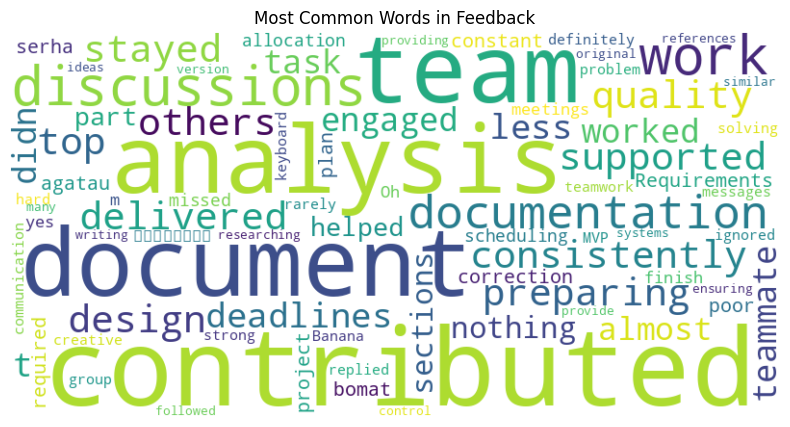

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_data = ' '.join(self_df['Brief Desceiption'].astype(str)) + ' ' + ' '.join(peer_df['Brief Desceiption'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Feedback')
plt.show()


##Self vs Peer Gap Analysis (Diverging bar chart)

In [ ]:
merged_df['gap'] = merged_df['self_avg'] - merged_df['peer_avg']
gap_chart = alt.Chart(merged_df).mark_bar().encode(
    x=alt.X('gap:Q', title='Self - Peer Score Difference'),
    y=alt.Y('Name:N', sort='-x'),
    color=alt.condition(
        alt.datum.gap > 0, alt.value('steelblue'), alt.value('tomato')
    ),
    tooltip=['Name','self_avg','peer_avg','gap']
).properties(title='Self vs Peer Score Gap (Over/Underestimation)')
gap_chart


alt.Chart(...)